<a href="https://colab.research.google.com/github/k3larra/gen1/blob/pc/shapes_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On concepts explanations and stuff like that.
This is the evaluate models part


# Setup

In [ ]:
import os
import csv
import cv2
import sys
import urllib
import json
import random
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.optim import lr_scheduler
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from os import listdir
from os.path import isfile, join
from io import StringIO 
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
from random import randint
from skimage import io, transform
print(torch.__version__)

1.12.0+cu113


In [ ]:
# Set random seed for reproducibility.
np.random.seed(131254)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/k3larra/XAI-F
#test data
with ZipFile('/content/XAI-F/testset.zip', 'r') as archive:
  archive.extractall('/content/testshapes')


fatal: destination path 'XAI-F' already exists and is not an empty directory.


## Dataloader


In [ ]:
# create the annotation file for the tests!
shape_path = "/content/testshapes"
with open(shape_path + '/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir(shape_path):
        # print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join(shape_path, dirs)):
            if(join(shape_path, dirs, f).endswith(".csv")):
                continue
            elif isfile(join(shape_path, dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [ ]:
num_classes = 4
possible_labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}
key_list = list(possible_labels.keys())
val_list = list(possible_labels.values())
def label_to_idx(label):
  return possible_labels[label]
def idx_to_label(idx):
  position = val_list.index(idx)
  return key_list[position]

## LOAD THE MODELS! 

In [ ]:
#And then training the model
#%%capture
#test_names=['resnet_50','resnet_152','inception_v3','efficientnet_b0']
test_name='resnet_50_4'
#path='/content/testshapes/study1/'
model_save_path = '/content/drive/MyDrive/ColabNotebooks/Phase3/Nature/'
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True # https://github.com/pytorch/pytorch/issues/61755
model_weights_no_pretrained = model_save_path + 'shapes_'+test_name+'_weights_model_not_pretrained.pth'
complete_model_no_pretrained = model_save_path + 'shapes_'+test_name+'_complete_model_not_pretrained.pth'
if test_name == 'resnet_50_4':
  model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
elif test_name == 'resnet_152':
  model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False)
elif test_name == 'inception_v3':
  model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
elif test_name == 'efficientnet_b0':
  model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=False)
else:
  print('OUPS')
model_ft.fc = nn.Linear(2048, 4)
model_ft = torch.load(complete_model_no_pretrained, map_location=torch.device(device))
#model_ft.load_state_dict(torch.load(model_weights_no_pretrained))
#model_ft.load_state_dict(torch.load(model_weights_no_pretrained,map_location=torch.device('cpu')))
model_ft.eval()
model_ft = model_ft.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# XAI Methods


In [ ]:
%%capture
! pip install captum lime cmapy grad-cam
from captum.attr import Occlusion
#from captum.attr import NoiseTunnel
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import visualization as viz
from skimage.segmentation import mark_boundaries
from lime import lime_image
import cmapy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
def show_image(image, prediction):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(prediction)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
eval_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)), ##Perhaps upsample to 224x224 i line with LIME
    ])
def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  if eval_transform:
      image = eval_transform(image)
  image = image.float()
  return image
        

## XAI METHODS separated in Functions to be called!

### LIME

In [ ]:
def get_preprocess_transform():
    # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                 std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([                              
        transforms.ToTensor(),
        transforms.Resize((299, 299)) #Added   
        # normalize #Do not whiten these images
    ])    
    return transf    
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model_ft.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    batch=batch.float()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ft.to(device)
    batch = batch.to(device)
    logits = model_ft(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def calculate_lime(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):
  input_img = input_img.squeeze()
  input_img= input_img.cpu().permute(1,2,0).detach().numpy().astype('double')
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(input_img, 
                                         batch_predict, # classification function
                                         top_labels=4,
                                         num_features=100000, #was 100000
                                         num_samples=1000,
                                         batch_size=10) 
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=False, num_features=5, hide_rest=False)
  #img_boundry1 = mark_boundaries(temp/255.0, mask)
  im = mark_boundaries(temp, mask,color=(0,0,1))
  plt.figure(figsize = (5,5))
  plt.axis('off')
  plt.imshow(im)
  plt.pause(0.01)
  if save:
    n=str(img_index + 1)
    plt.imsave(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_'+str(int(np.round(top_probs[0].item(),2)*100))+ '_LIME.PNG',im)
    #im.save(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_'+str(int(np.round(top_probs[0].item(),2)*100))+ '_LIME.PNG')
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))

In [ ]:
def calculate_gradcam(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):
  input_img.requires_grad = True
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  if test_name == 'resnet_50_4':
    cam = GradCAM(model=experiment_model, target_layers=[experiment_model.layer4[2].conv3], use_cuda=False)
  elif test_name == 'resnet_152':
    print('resnet_152')
    cam = GradCAM(model=experiment_model, target_layers=[experiment_model.layer4[2].conv3], use_cuda=False)
  elif test_name == 'inception_v3':
    print('inception_v3')
    cam = GradCAM(model=experiment_model, target_layers=[experiment_model.Mixed_7c.branch_pool.conv], use_cuda=False)
  elif test_name == 'efficientnet_b0':
    print('efficientnet_b0')
    cam = GradCAM(model=experiment_model, target_layers=[experiment_model.features.conv], use_cuda=False)
  else:
    print('no layer')
  targ = [ClassifierOutputTarget(target_label)]
  grayscale_cam = cam(input_tensor=input_img, targets=targ)
  grayscale_cam = grayscale_cam[0, :]
  input_img = input_img.squeeze()
  #visualization = show_cam_on_image(input_img.cpu().permute(1,2,0).detach().numpy(), grayscale_cam, use_rgb=True,colormap=cmapy.cmap('RdYlGn')
  visualization = show_cam_on_image(input_img.cpu().permute(1,2,0).detach().numpy(), grayscale_cam, use_rgb=True)
  plt.figure(figsize = (5,5))
  plt.axis('off')
  plt.imshow(visualization) 
  if save:
    n=str(img_index + 1)
    im = Image.fromarray(visualization)
    im.save(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_'+str(int(np.round(top_probs[0].item(),2)*100))+ '_GC_other.PNG')
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))

In [ ]:
def calculate_layered_gradcam(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):
  input_img.requires_grad = True
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  if test_name == 'resnet_50_4':
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.layer4[2].conv3)
  elif test_name == 'resnet_152':
    print('resnet_152')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.layer4[2].conv3)
  elif test_name == 'inception_v3':
    print('inception_v3')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.Mixed_7c.branch_pool.conv)
  elif test_name == 'efficientnet_b0':
    print('efficientnet_b0')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.features.conv)
  else:
    print('no layer')
  attributions = layer_gradcam.attribute(input_img, target=target_label)
  attributions = LayerAttribution.interpolate(attributions, input_img.shape[2:])
  input_img = input_img.squeeze()
  attr_combined = np.sum(attributions[0].cpu().permute(1,2,0).detach().numpy(), axis=2)
  attr_combined = (attr_combined > 0) * attr_combined
  outlier_perc = 100 - 2
  sorted_vals = np.sort(attr_combined.flatten())
  cum_sums = np.cumsum(sorted_vals)
  threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * outlier_perc)[0][0]
  threshold = sorted_vals[threshold_id]
  result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                              input_img.cpu().permute(1,2,0).detach().numpy(), 
                              method="blended_heat_map",
                              sign="all",
                              fig_size=(5,5))
  if save:
    n=str(img_index + 1)
    result[0].savefig(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) +'_'+str(int(np.round(top_probs[0].item(),2)*100)) + '_GC.PNG',bbox_inches='tight', pad_inches = 0)
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))

In [ ]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  occlusion = Occlusion(experiment_model)
  attributions = occlusion.attribute(input_img,
                                   strides = (3, 8, 8),
                                   sliding_window_shapes=(3,15,15),
                                   target=target_label,
                                   baselines = 0)
  input_img = input_img.squeeze()
  attr_combined = np.sum(attributions.squeeze().cpu().permute(1,2,0).detach().numpy(), axis=2)
  attr_combined = (attr_combined > 0) * attr_combined
  outlier_perc = 100 - 2
  sorted_vals = np.sort(attr_combined.flatten())
  cum_sums = np.cumsum(sorted_vals)
  threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * outlier_perc)[0][0]
  threshold = sorted_vals[threshold_id]
  result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                              input_img.cpu().permute(1,2,0).detach().numpy(), 
                              method="blended_heat_map",
                              sign="all",
                              fig_size=(5,5))
  if save:
    n=str(img_index + 1)
    result[0].savefig(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_'+str(int(np.round(top_probs[0].item(),2)*100))+'_Occ.PNG',bbox_inches='tight', pad_inches = 0)
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))

# Helpers

In [ ]:
def eval_model(experiment_set, test_model, print_eval=False):
  since = time.time()
  test_model.eval()   # Set model to evaluate mode
  for experiment_sample in experiment_set:
    torch.set_printoptions(sci_mode=False)
    with torch.no_grad():
      input = experiment_sample
      input = torch.unsqueeze(input, 0)
      input = input.to(device)
      #print(input.shape)
      output = test_model(input)
      _, pred = torch.max(output, 1)

      input= input.cpu().squeeze()
      smax = F.softmax(output,dim=1)
      print("prediction: ", pred, ", label: ", idx_to_label(pred))

      if print_eval:
        show_image(input.permute(1,2,0), idx_to_label(pred))
        print(smax)
        print("---------")
def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  return loaded_files
def load_experiment_data(experiment_path, test_model, plot_data=False, evaluate_model=False, print_evaluation=False):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i],eval_transform))
  if plot_data:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        img = experiment_set[i-1] # index dataset (gets you the img and label - index)
        figure.add_subplot(rows, cols, i)
        plt.title(img.shape)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
    plt.show() 
  if evaluate_model:
    eval_model(experiment_set, test_model, print_evaluation)
  return experiment_set

In [ ]:
def process_input(input_img, experiment_model, debug=False):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),9)
      if top_catid[i].item()<4: #Aj
        prediction["label"] = idx_to_label(top_catid[i])
        prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  if debug:
    print(jsonData)
  return top_catid, top_prob, jsonData

In [ ]:
def run_experiment_shapes(experiment_model, experiment_path, experiment_name, save_path="", label_id=0, save=False, debug=False):
  print(experiment_name)
  experiment_set = load_experiment_data(experiment_path,  experiment_model, plot_data=False, evaluate_model = False, print_evaluation=False)
  print("------------------")
  path_to_save = save_path + experiment_name.replace(" ", "") + "/"
  print("Save Path: ", path_to_save)
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  json_data = {}
  # if index == -1: # Iterate all the experiment set! else only the specific index is 
  for idx, experiment_sample in enumerate(experiment_set):
    ignore_indices = []
    if idx in ignore_indices:
      continue
    experiment_sample = experiment_sample.unsqueeze(0)
    top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
    json_data[idx] = jdata
    print("Selected label: ", top_candidates[label_id] )
    print("target_label: ", top_candidates[label_id].item())
    calculate_lime(experiment_model, 
                      target_label=top_candidates[label_id].item(),
                      input_img=experiment_sample,
                      top_candidates=top_candidates, 
                      top_probs=top_probs,
                      img_index=idx, save_path=path_to_save, save=save)                  
    calculate_gradcam(experiment_model, 
                      target_label=top_candidates[label_id].item(),
                      input_img=experiment_sample,
                      top_candidates=top_candidates, top_probs=top_probs,
                      img_index=idx, save_path=path_to_save, save=save)
    
    calculate_layered_gradcam(experiment_model, 
                     target_label=top_candidates[label_id].item(),
                     input_img=experiment_sample,
                     top_candidates=top_candidates, top_probs=top_probs,
                     img_index=idx, save_path=path_to_save, save=save)
    
    calculate_occlusion(experiment_model, 
                            target_label=top_candidates[label_id],
                            input_img=experiment_sample,
                            top_candidates=top_candidates, top_probs=top_probs,
                            img_index=idx, save_path=path_to_save, save=save)      
  save_json = json.dumps(json_data)
  with open(path_to_save + 'label_info.json', 'w') as outfile:
    outfile.write(save_json)

# Experiments!

STUDY1_no_pret_resnet_50_4m_v4
------------------
Save Path:  /content/drive/MyDrive/ColabNotebooks/Phase3/Nature/study2/STUDY1_no_pret_resnet_50_4m_v4/
{0: {'probability': 0.993767023, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.006232847, 'label': 'square', 'labelid': 1}, 2: {'probability': 9.5e-08, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

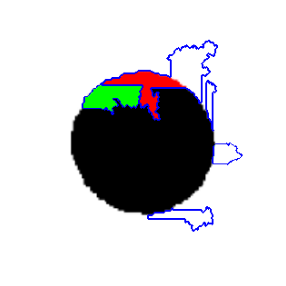

0 circle 0.99
0 circle 0.99


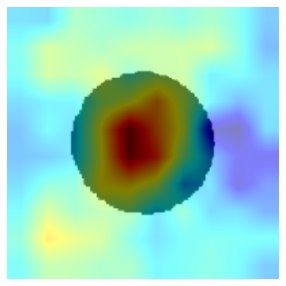

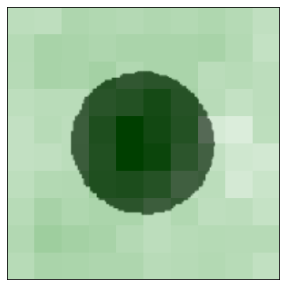

0 circle 0.99


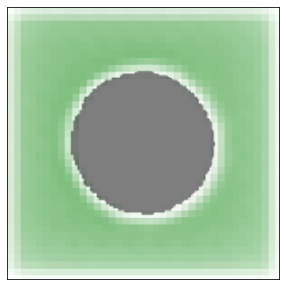

tensor(0, device='cuda:0') circle 0.99
{0: {'probability': 0.998875678, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.000876424, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.000247973, 'label': 'circle', 'labelid': 0}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

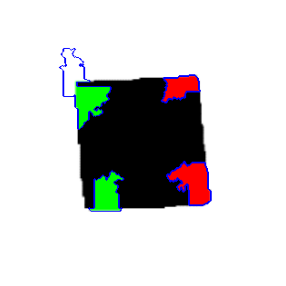

1 square 1.0
1 square 1.0


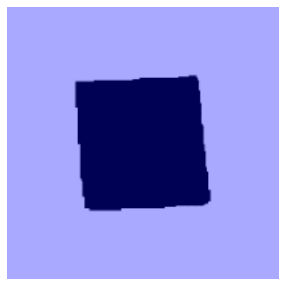

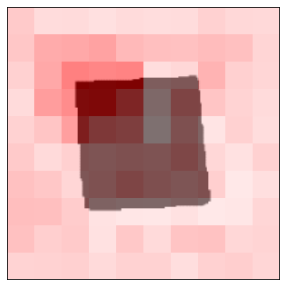

1 square 1.0


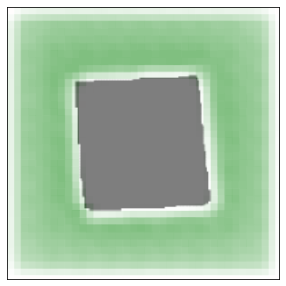

tensor(1, device='cuda:0') square 1.0
{0: {'probability': 0.999999762, 'label': 'star', 'labelid': 2}, 1: {'probability': 2.94e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

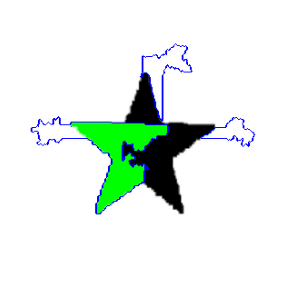

2 star 1.0
2 star 1.0


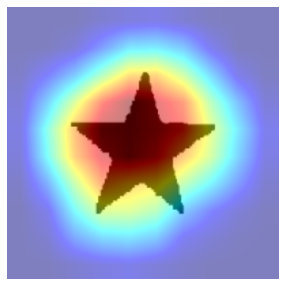

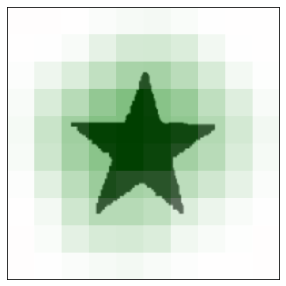

2 star 1.0


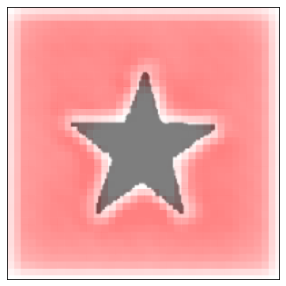

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.995608509, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.004319238, 'label': 'square', 'labelid': 1}, 2: {'probability': 7.2252e-05, 'label': 'star', 'labelid': 2}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

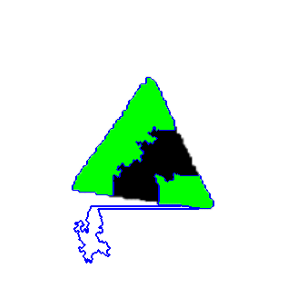

3 triangle 1.0
3 triangle 1.0


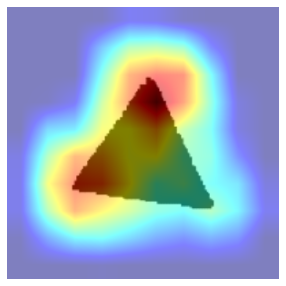

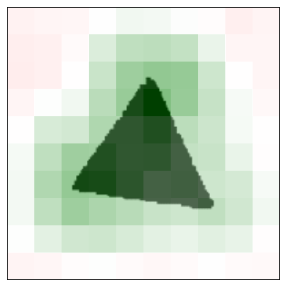

3 triangle 1.0


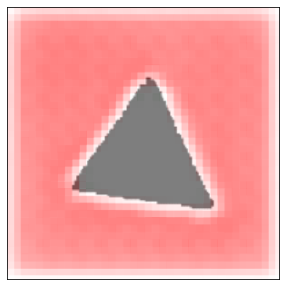

tensor(3, device='cuda:0') triangle 1.0
{0: {'probability': 0.99531436, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.004685422, 'label': 'square', 'labelid': 1}, 2: {'probability': 1.85e-07, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

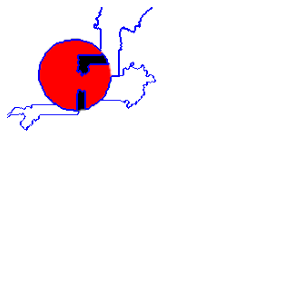

0 circle 1.0
0 circle 1.0


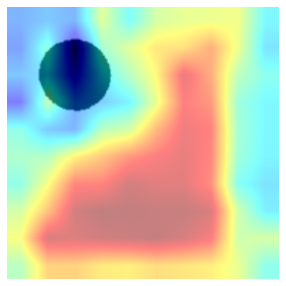

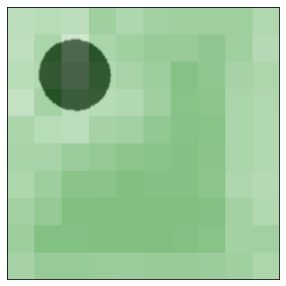

0 circle 1.0


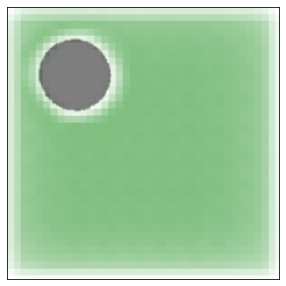

tensor(0, device='cuda:0') circle 1.0
{0: {'probability': 0.995497227, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.002265262, 'label': 'circle', 'labelid': 0}, 2: {'probability': 0.002237553, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

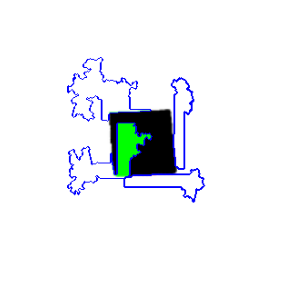

1 square 1.0
1 square 1.0


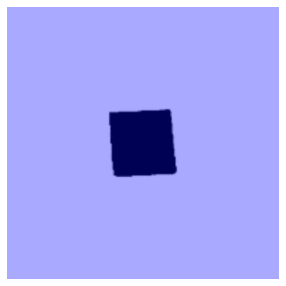

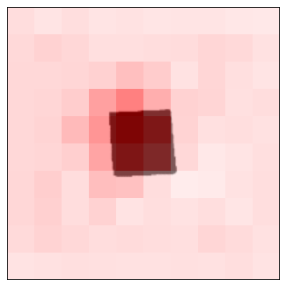

1 square 1.0


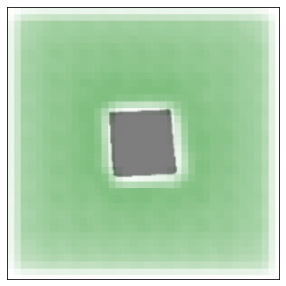

tensor(1, device='cuda:0') square 1.0
{0: {'probability': 0.99990201, 'label': 'star', 'labelid': 2}, 1: {'probability': 9.7994e-05, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

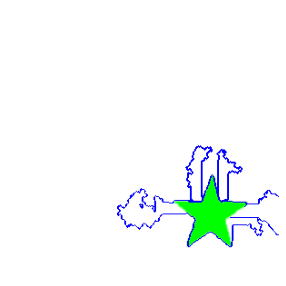

2 star 1.0
2 star 1.0


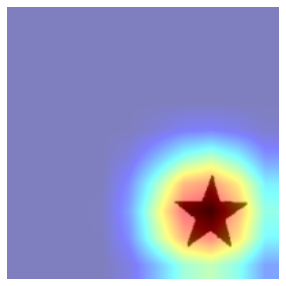

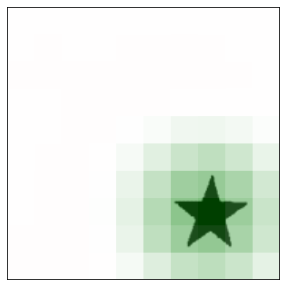

2 star 1.0


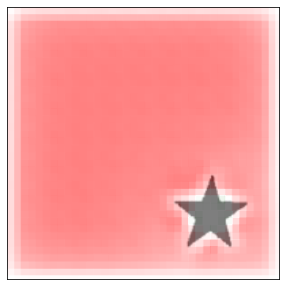

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.996976256, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.002762944, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.000260776, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

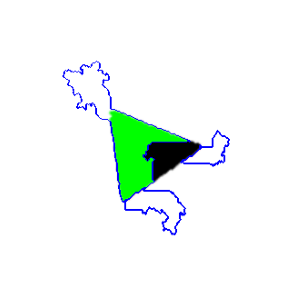

3 triangle 1.0
3 triangle 1.0


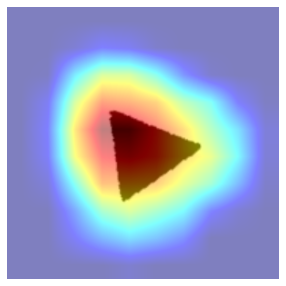

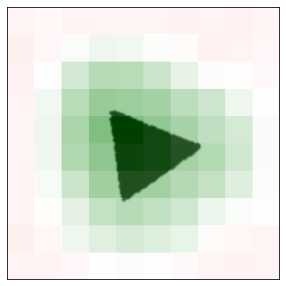

3 triangle 1.0


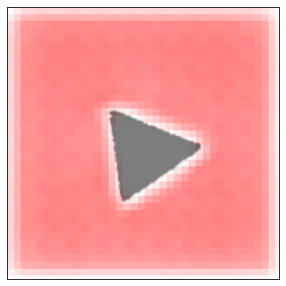

tensor(3, device='cuda:0') triangle 1.0
{0: {'probability': 0.998190105, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.001532424, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.000277445, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

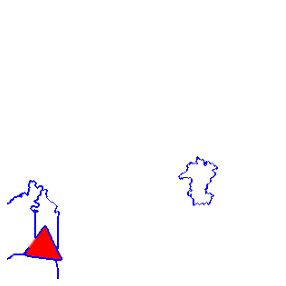

3 triangle 1.0
3 triangle 1.0


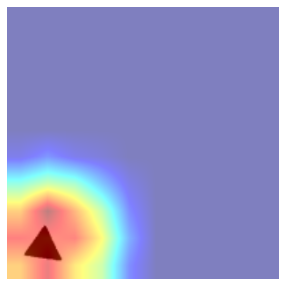

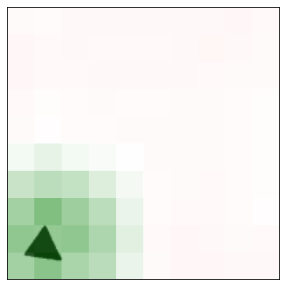

3 triangle 1.0


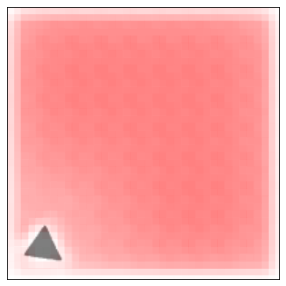

tensor(3, device='cuda:0') triangle 1.0
STUDY2_no_pret_resnet_50_4m_v4
------------------
Save Path:  /content/drive/MyDrive/ColabNotebooks/Phase3/Nature/study2/STUDY2_no_pret_resnet_50_4m_v4/
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

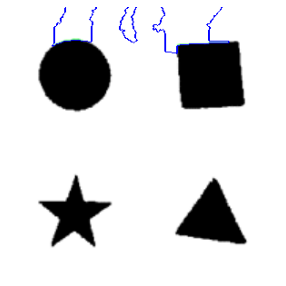

2 star 1.0
2 star 1.0


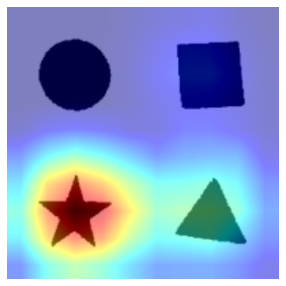

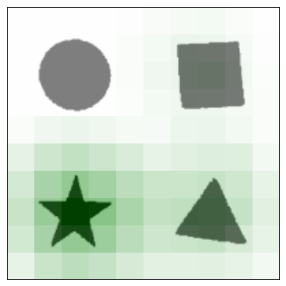

2 star 1.0


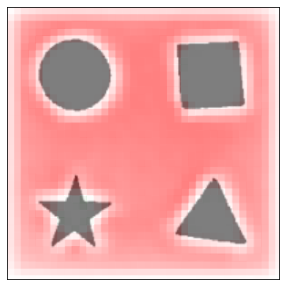

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

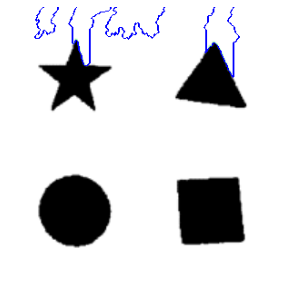

2 star 1.0
2 star 1.0


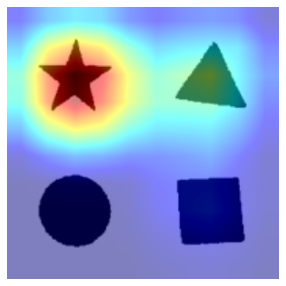

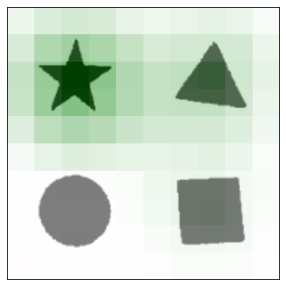

2 star 1.0


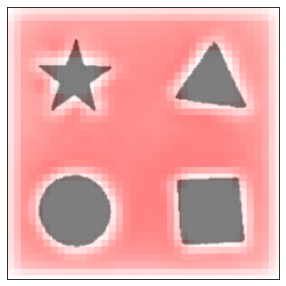

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.890630305, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.109365299, 'label': 'square', 'labelid': 1}, 2: {'probability': 4.406e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

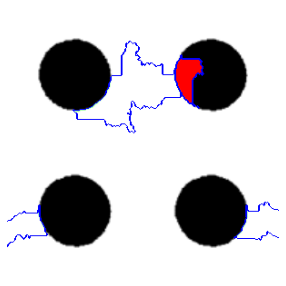

0 circle 0.89
0 circle 0.89


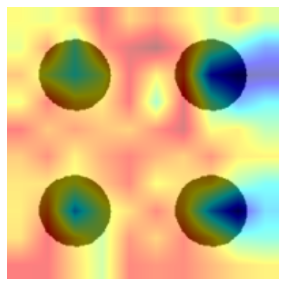

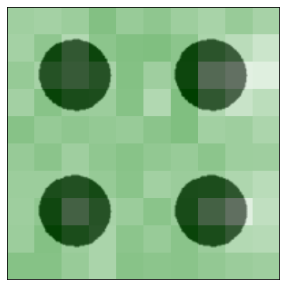

0 circle 0.89


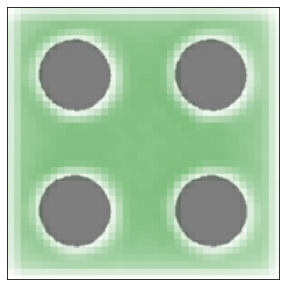

tensor(0, device='cuda:0') circle 0.89
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'circle', 'labelid': 0}, 3: {'probability': 0.0, 'label': 'square', 'labelid': 1}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

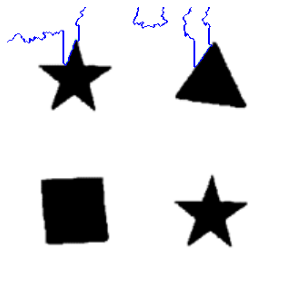

2 star 1.0
2 star 1.0


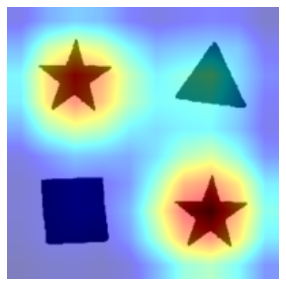

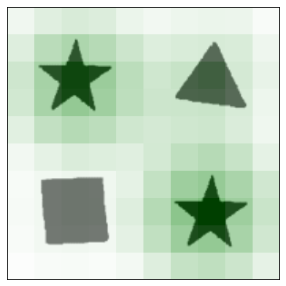

2 star 1.0


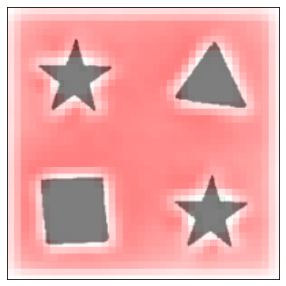

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

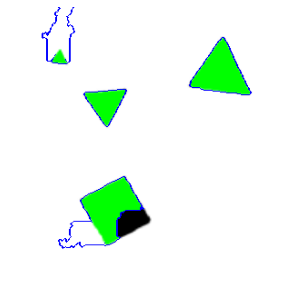

2 star 1.0
2 star 1.0


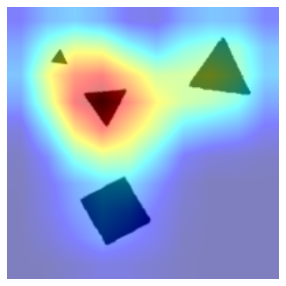

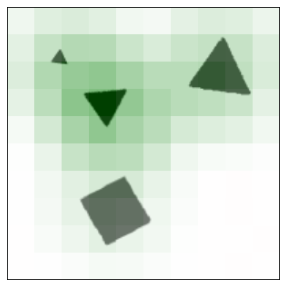

2 star 1.0


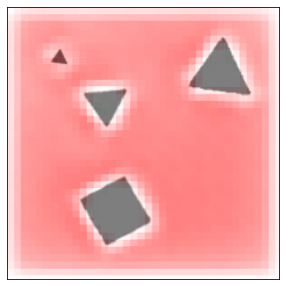

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

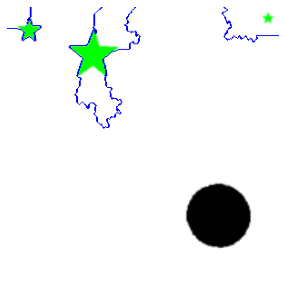

2 star 1.0
2 star 1.0


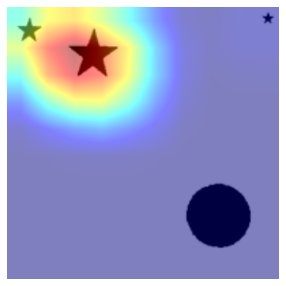

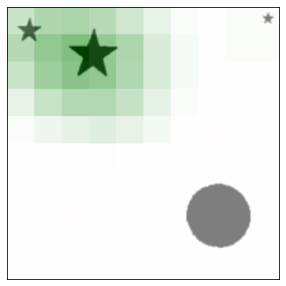

2 star 1.0


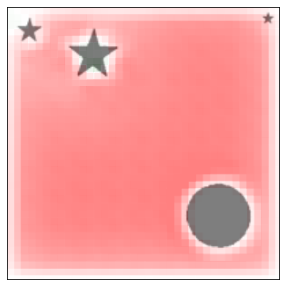

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.926318288, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.073672272, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 9.236e-06, 'label': 'circle', 'labelid': 0}, 3: {'probability': 9.5e-08, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

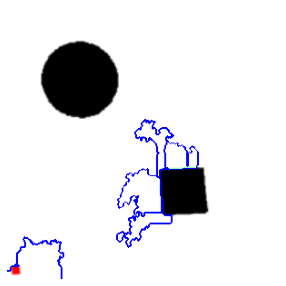

1 square 0.93
1 square 0.93


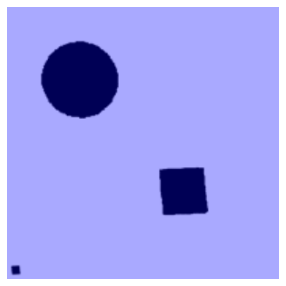

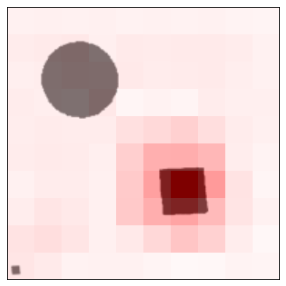

1 square 0.93


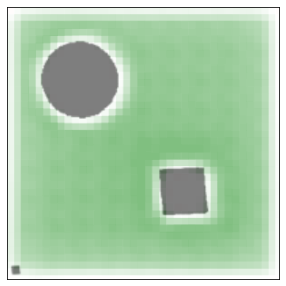

tensor(1, device='cuda:0') square 0.93
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'circle', 'labelid': 0}, 3: {'probability': 0.0, 'label': 'square', 'labelid': 1}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

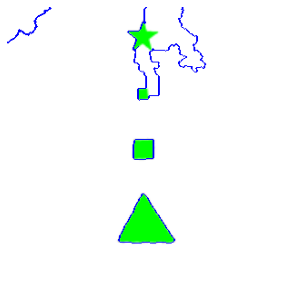

2 star 1.0
2 star 1.0


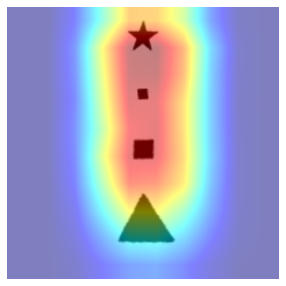

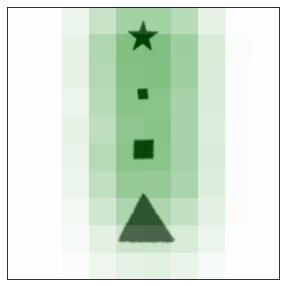

2 star 1.0


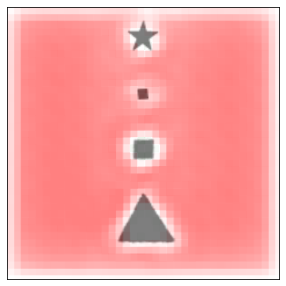

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.999999881, 'label': 'star', 'labelid': 2}, 1: {'probability': 1.45e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

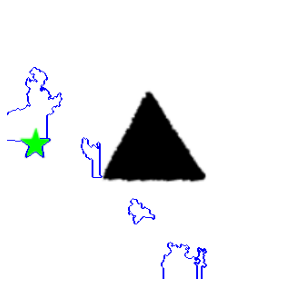

2 star 1.0
2 star 1.0


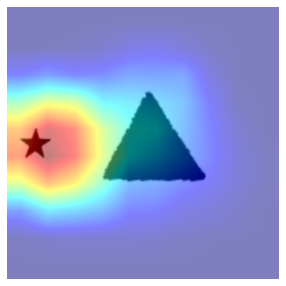

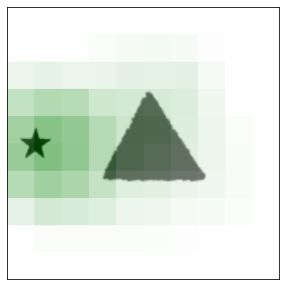

2 star 1.0


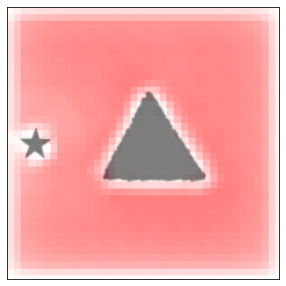

tensor(2, device='cuda:0') star 1.0
STUDY3_no_pret_resnet_50_4m_v4
------------------
Save Path:  /content/drive/MyDrive/ColabNotebooks/Phase3/Nature/study2/STUDY3_no_pret_resnet_50_4m_v4/
{0: {'probability': 0.996832073, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.003167969, 'label': 'square', 'labelid': 1}, 2: {'probability': 1.3e-08, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

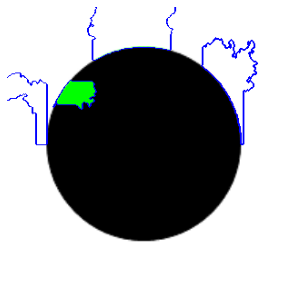

0 circle 1.0
0 circle 1.0


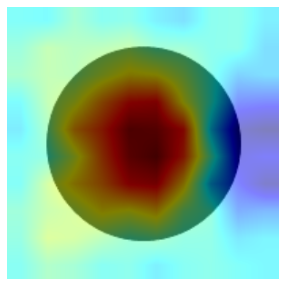

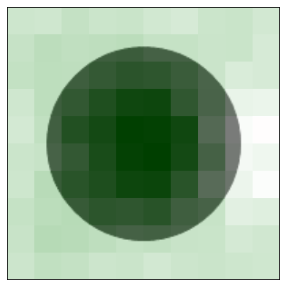

0 circle 1.0


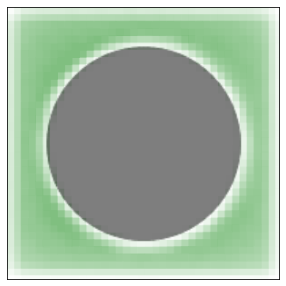

tensor(0, device='cuda:0') circle 1.0
{0: {'probability': 0.9914096, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.007521415, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.001068956, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

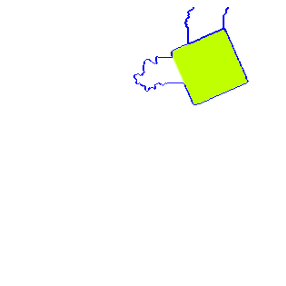

3 triangle 0.99
3 triangle 0.99


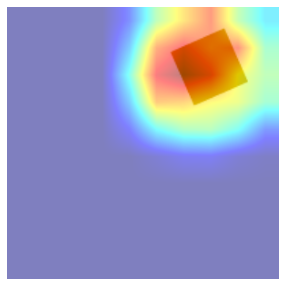

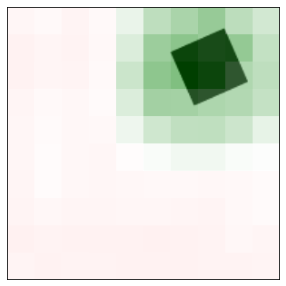

3 triangle 0.99


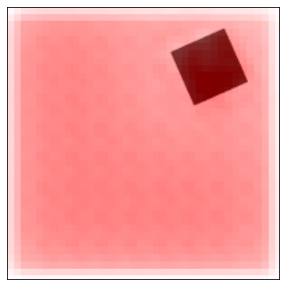

tensor(3, device='cuda:0') triangle 0.99
{0: {'probability': 0.935324848, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.064672649, 'label': 'square', 'labelid': 1}, 2: {'probability': 2.524e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

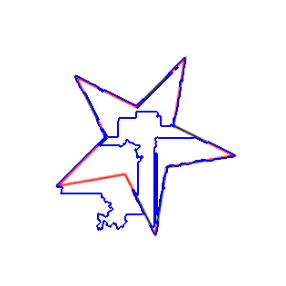

0 circle 0.94
0 circle 0.94


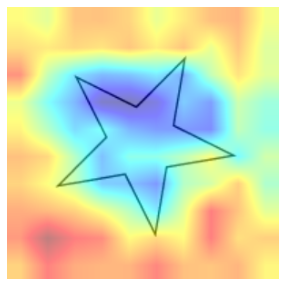

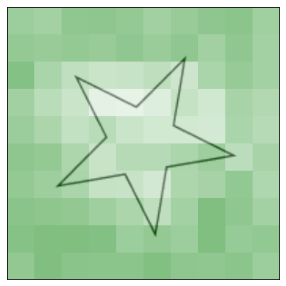

0 circle 0.94


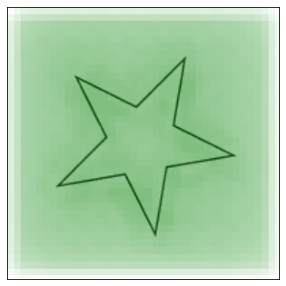

tensor(0, device='cuda:0') circle 0.94
{0: {'probability': 0.678848803, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.321150839, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 3.64e-07, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

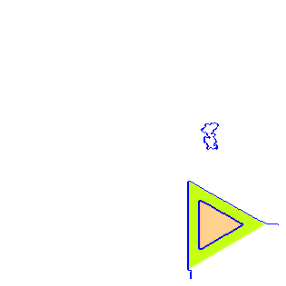

2 star 0.68
2 star 0.68


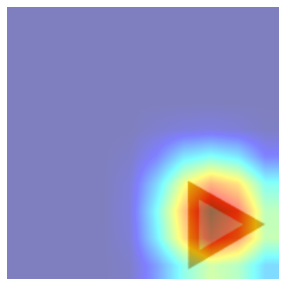

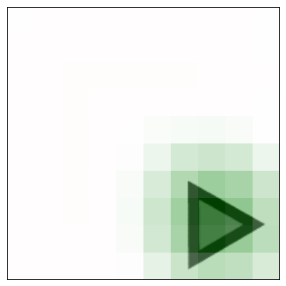

2 star 0.68


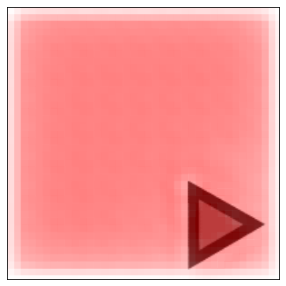

tensor(2, device='cuda:0') star 0.68
{0: {'probability': 0.986090541, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.01390885, 'label': 'square', 'labelid': 1}, 2: {'probability': 6.41e-07, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

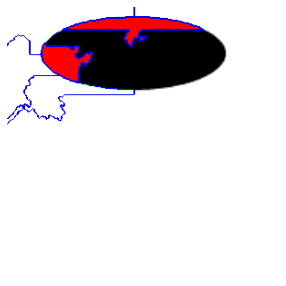

0 circle 0.99
0 circle 0.99


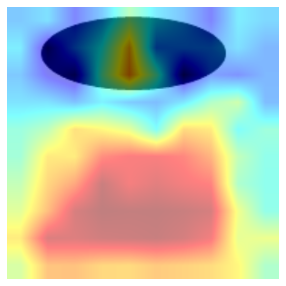

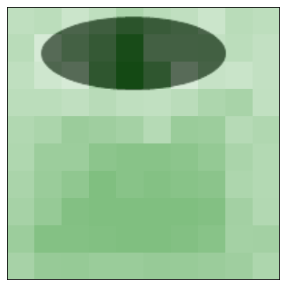

0 circle 0.99


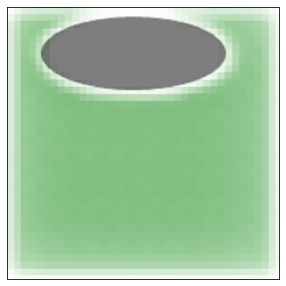

tensor(0, device='cuda:0') circle 0.99
{0: {'probability': 0.997789741, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.001231587, 'label': 'circle', 'labelid': 0}, 2: {'probability': 0.000978738, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

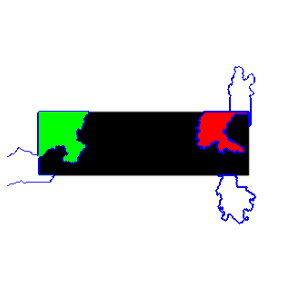

1 square 1.0
1 square 1.0


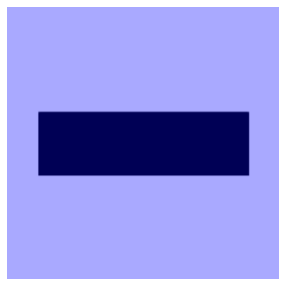

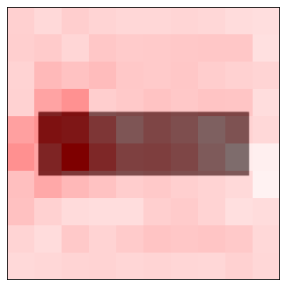

1 square 1.0


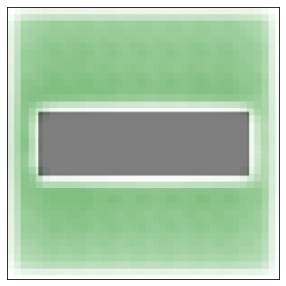

tensor(1, device='cuda:0') square 1.0
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'circle', 'labelid': 0}, 3: {'probability': 0.0, 'label': 'square', 'labelid': 1}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

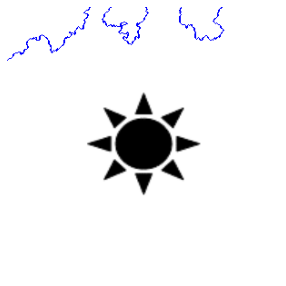

2 star 1.0
2 star 1.0


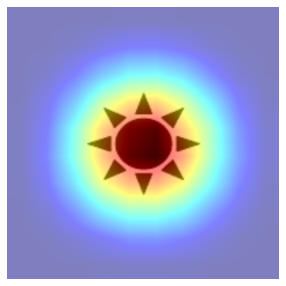

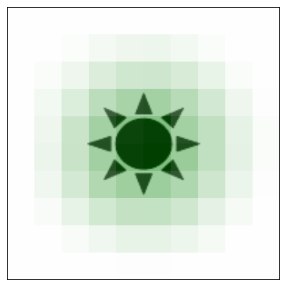

2 star 1.0


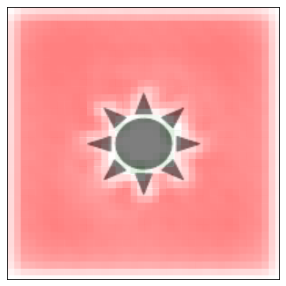

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.984972954, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.014618545, 'label': 'square', 'labelid': 1}, 2: {'probability': 0.000408459, 'label': 'star', 'labelid': 2}, 3: {'probability': 1e-09, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

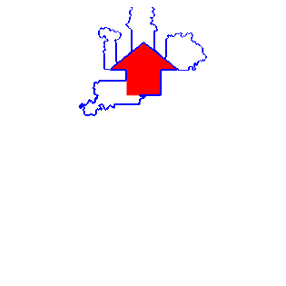

3 triangle 0.98
3 triangle 0.98


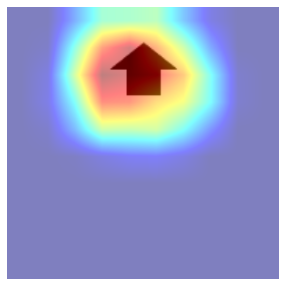

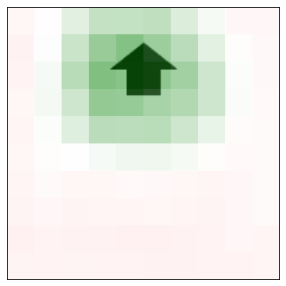

3 triangle 0.98


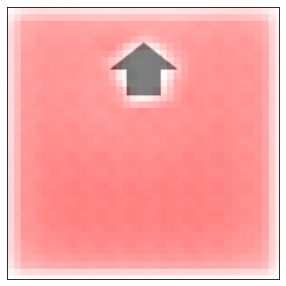

tensor(3, device='cuda:0') triangle 0.98
{0: {'probability': 0.589690268, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.410230637, 'label': 'circle', 'labelid': 0}, 2: {'probability': 7.9083e-05, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


  0%|          | 0/1000 [00:00<?, ?it/s]

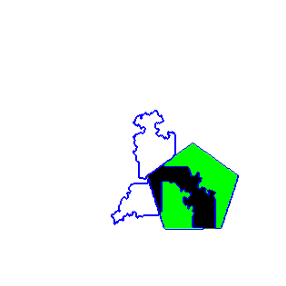

1 square 0.59
1 square 0.59


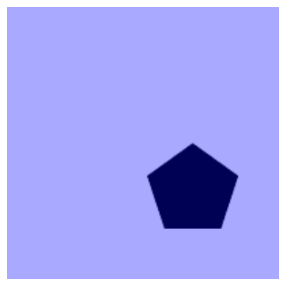

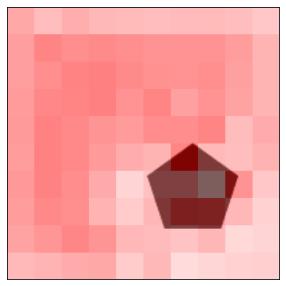

1 square 0.59


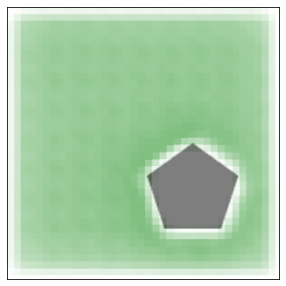

tensor(1, device='cuda:0') square 0.59


In [ ]:

XAI_save_path = '/content/drive/MyDrive/ColabNotebooks/Phase3/Nature/study2/'
extra_spec = 'm_v4'
run_experiment_shapes(model_ft, "/content/testshapes/study1/", "STUDY1_no_pret_"+test_name+extra_spec, XAI_save_path, 0, True, True)
run_experiment_shapes(model_ft, "/content/testshapes/study2/", "STUDY2_no_pret_"+test_name+extra_spec, XAI_save_path, 0, True, True)
run_experiment_shapes(model_ft, "/content/testshapes/study3/", "STUDY3_no_pret_"+test_name+extra_spec, XAI_save_path, 0, True, True)